# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 2 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0

https://drive.google.com/open?id=1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0': 'test.npz',
'1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80': 'train.npz',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


# Basic Imports

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from skimage.transform import resize


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2.1 VAE

## VAE Dataset

In [0]:
train_dataset = datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))

test_dataset = datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ]))


## VAE Data Loader

In [0]:
train_data_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

test_recon_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## VAE Model Definition

In [0]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
    self.fc2a = nn.Sequential(nn.Linear(400, 20), nn.ReLU())
    self.fc2b = nn.Sequential(nn.Linear(400, 20), nn.ReLU())
    
    self.fc3 = nn.Sequential(nn.Linear(20, 400), nn.ReLU())
    self.fc4 = nn.Sequential(nn.Linear(400, 784), nn.Sigmoid())
  
  def sample_z(self, mu, sigma):
    z = torch.randn_like(mu) * sigma + mu
    return z
  
  def encoder(self, X):
    fc1_out = self.fc1(X)
    mu = self.fc2a(fc1_out)
    ln_var = self.fc2b(fc1_out)
    return mu, ln_var.exp()
  
  def decoder(self, z):
    fc3_out = self.fc3(z)
    fc4_out = self.fc4(fc3_out)
    return fc4_out
    
  def forward(self, X):
    X = X.view(-1, 784)
    mu, var = self.encoder(X)
    sigma = torch.sqrt(var)
    z = self.sample_z(mu, sigma)
    decoder_out = self.decoder(z)
    return mu, var, decoder_out
  

## VAE Loss Function

In [0]:
def loss_function(mu, var, decoder_out, x_input):
  KLD = -0.5 * torch.sum( 1 + torch.log(var) - mu.pow(2) - var)
  reconstruction_error = F.binary_cross_entropy(decoder_out, x_input, reduction='sum')
  return reconstruction_error , KLD


## VAE Wrapper

In [0]:
class VAEWrapper():
  def __init__(self, vae, lr):
    self.vae = vae.to(device)
    self.adam = torch.optim.Adam(self.vae.parameters())
    self.train_loss_data, self.test_loss_data = [], []
    self.infer_out = []
  
  def infer_data(self, X):
    with torch.no_grad():
      n_input = torch.tensor(X).type(torch.float).to(device)
      mu, var, decoder_out = self.vae(n_input)
      image_out = decoder_out.view(-1, 28, 28).cpu()
      return image_out
  
  def infer_data_from_loader(self, data_loader):
    main_out = []
    with torch.no_grad():
      for batch_id, (samples, labels) in enumerate(data_loader):
        samples = samples.to(device)
        _, _, output = self.vae(samples)
        main_out.append(output.detach().cpu().view(-1, 28, 28))
    return main_out

    
  def train_network(self, data_loader, epoch=0): 
    for batch_id, (samples, labels) in enumerate(data_loader):
      self.adam.zero_grad()
      samples_flat = samples.view(-1, 784).to(device)
      mu, var, decoder_out = self.vae(samples_flat)
      recon_loss, kld_loss = loss_function(mu, var, decoder_out, samples_flat)
      loss = (recon_loss + kld_loss) * 1.0 / samples.shape[0]
      loss.backward()
      self.adam.step()

      if batch_id % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * samples.shape[0], len(data_loader.dataset),
                samples.shape[0] * batch_id / len(data_loader), loss.item() / samples.shape[0]))
  
  def test_network(self, data_loader, print_prefix='Train', epoch_num=0):

    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    batch_count = 0
    sample_count = 0

    with torch.no_grad():
      for batch_id, (samples, labels) in enumerate(data_loader):
        samples_flat = samples.view(-1, 784).to(device)
        mu, var, decoder_out = self.vae(samples_flat)
        recon_loss, kld_loss = loss_function(mu, var, decoder_out, samples_flat)
        loss = recon_loss + kld_loss
        
        total_recon_loss += recon_loss.item()
        total_kld_loss += kld_loss.item()
        total_loss += loss.item()

        batch_count += 1
        sample_count += samples.shape[0]
    
    loss_info = np.array([total_recon_loss, total_kld_loss, total_loss])
    loss_record = [loss_info, batch_count, sample_count]

    print(print_prefix + " Epoch : {}, Loss: {}, Recon_Loss: {}, KLD_Loss: {}".format(epoch_num, loss_info[-1]/sample_count, loss_info[0]/sample_count, loss_info[1]/sample_count))
    return loss_record


## VAE Training

In [0]:
vae = VAE()
nw = VAEWrapper(vae, 0.001)

for  epoch in range(50):
  nw.train_network(train_data_loader)
  train_loss = nw.test_network(train_data_loader, print_prefix='Train', epoch_num=epoch+1)
  test_loss = nw.test_network(test_data_loader, print_prefix='Test', epoch_num=epoch + 1)

  nw.train_loss_data.append(train_loss)
  nw.test_loss_data.append(test_loss)

  test_infer_out = nw.infer_data_from_loader(test_recon_loader)
  nw.infer_out.append(test_infer_out)



Train Epoch: 0 [0/60000 (0%)]	Loss: 5.491292
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.038597
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.812299
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.773355
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.773459
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.642642
Train Epoch : 1, Loss: 166.0086133951823, Recon_Loss: 149.9522997721354, KLD_Loss: 16.05631377766927
Test Epoch : 1, Loss: 165.5425529296875, Recon_Loss: 149.12031796875, KLD_Loss: 16.42223494873047
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.686969
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.649244
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.668156
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.593008
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.673275
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.629853
Train Epoch : 2, Loss: 160.9716291829427, Recon_Loss: 141.96920940755209, KLD_Loss: 19.00241982421875
Test Epoch : 2, Loss: 160.40404921875, Recon_Loss: 140.84818486328126, KLD_Loss: 19.555864038085936
Train Epo

## VAE Reconstruction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


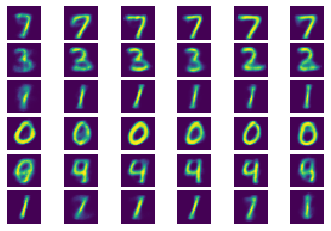

In [0]:
# nw = VAEWrapper(vae, 0.001)

# nw.infer_data(test_dataset[10][0])
from matplotlib import gridspec

def plot_grid(data, index_list, sample_size):
  # f, axarr = plt.subplots(sample_size, len(index_list))
  gs = gridspec.GridSpec(sample_size, len(index_list), width_ratios=[1 for k in range(len(index_list))],
         wspace=0.1, hspace=0.1) 

  for i, index in enumerate(index_list):
    sample = data[index][0][:sample_size, :, :]
    for s_index in range(sample_size):
      #axarr[s_index, i].imshow(sample[s_index, :, :])
      plt.subplot(gs[s_index, i]).imshow(sample[s_index, :, :])
      plt.subplot(gs[s_index, i]).axis('off')
  
  plt.axis('off')
  plt.show()


plot_grid(nw.infer_out, [1,5,15, 20, 25, 30], 6)



# 2.2 DCGAN

# 3 CIS GAN

## Data set

In [0]:
class CISDataset():
  def __init__(self, input_path):
    load_data = np.load(input_path)
    self.data = load_data['arr_0'] / 255.0
    self.length = self.data.shape[0]
    del load_data
  
  def __len__(self):
    return self.length 
  
  def __getitem__(self, index):
    image = self.data[index, :, :, :]
    down_sample_image = resize(image, (16, 16))
    up_sample_image = resize(down_sample_image, (64, 64))
    trans_image, trans_blur = np.moveaxis(image, -1, 0), np.moveaxis(up_sample_image, -1, 0)
    return trans_image, trans_blur

def custom_collate(batch):
  return default_collate(batch)


In [0]:
cis_train_data_set = CISDataset('train.npz')
cis_test_data_set = CISDataset('test.npz')

cis_train_data_loader = DataLoader(cis_train_data_set, collate_fn=custom_collate, batch_size=10, shuffle=True)
cis_test_data_loader = DataLoader(cis_test_data_set, collate_fn=custom_collate, batch_size=10, shuffle=True)


In [0]:
image, blur = cis_train_data_set[8]

plt.imshow(np.moveaxis(image, 0, -1))
plt.show()
plt.imshow(np.moveaxis(blur, 0, -1))
plt.show()


## CIS Model Definition

In [0]:
class CISEncoder(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU())
    self.layer4 = nn.Sequential(nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU())
    self.layer5 = nn.Sequential(nn.Conv2d(256, 512, 4, stride=2, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU())
  
  def forward(self, X):
    l1_out = self.layer1(X)
    l2_out = self.layer2(l1_out)
    l3_out = self.layer3(l2_out)
    l4_out = self.layer4(l3_out)
    l5_out = self.layer5(l4_out)
    return (l1_out, l2_out, l3_out, l4_out, l5_out)

class CISDecoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(512 + 512, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.ConvTranspose2d(128+128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU())
    self.layer4 = nn.Sequential(nn.ConvTranspose2d(64+64, 32, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU())
    self.layer5 = nn.Sequential(nn.ConvTranspose2d(32+32, 16, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(16), nn.LeakyReLU())
    self.layer6 = nn.Sequential(nn.ConvTranspose2d(16+3, 3, kernel_size=3, padding=1), nn.Tanh())

  def forward(self, encoder_out, inp_x, inp_z):
    l1_out = self.layer1(torch.cat([inp_z,  encoder_out[4]], dim=1))
    l2_out = self.layer2(torch.cat([l1_out, encoder_out[3]], dim=1))
    l3_out = self.layer3(torch.cat([l2_out, encoder_out[2]], dim=1))
    l4_out = self.layer4(torch.cat([l3_out, encoder_out[1]], dim=1))
    l5_out = self.layer5(torch.cat([l4_out, encoder_out[0]], dim=1))
    l6_out = self.layer6(torch.cat([l5_out, inp_x], dim=1))

    return l6_out

class CISGenerator(torch.nn.Module):
  def __init__(self, ce, cd):
    super().__init__()
    self.ce = ce
    self.cd = cd
  
  def forward(self, inp_x, inp_z):
    ot = self.ce(inp_x)
    od = self.cd(ot, inp_x, inp_z)
    return od

class CISDisc(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU())
    self.layer4 = nn.Sequential(nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU())
    self.layer5 = nn.Sequential(nn.Conv2d(256, 512, 4, stride=2, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU())
    self.layer6 = nn.Sequential(nn.Conv2d(512, 1, 3, stride=2, padding=1), nn.Sigmoid())
  
  def forward(self, X):
    l1_out = self.layer1(X)
    l2_out = self.layer2(l1_out)
    l3_out = self.layer3(l2_out)
    l4_out = self.layer4(l3_out)
    l5_out = self.layer5(l4_out)
    l6_out = self.layer6(l5_out)

    return l6_out 


ce = CISEncoder().to(device)
cd = CISDecoder().to(device)

cgen = CISGenerator(ce, cd).to(device)
cdisc = CISDisc().to(device)

inp_x = torch.zeros((10, 3, 64, 64)).type(torch.float).to(device)
inp_z = torch.zeros((10, 512, 2, 2)).type(torch.float).to(device)

opt = cgen(inp_x, inp_z)
out = cdisc(opt)


torch.Size([10, 1, 1, 1])


## CIS Model Wrapper

In [0]:
REAL_LABEL = 1.0
FAKE_LABEL = 0.0

class CISModelWrapper():
  def __init__(self, cgen, cdisc, lr_gen, lr_disc):
    self.cgen = cgen
    self.cdisc = cdisc
    self.optimizerG = torch.optim.Adam(self.cgen.parameters(), lr=lr_gen)
    self.optimizerD = torch.optim.Adam(self.cdisc.parameters(), lr=lr_disc)
  
  def train_samples_disc(self, samples, noise):
      
    self.cdisc.zero_grad()
    noise = noise.to(device)

    batch_size = samples.shape[0]  
    real_samples = samples.to(device)
    real_labels = torch.full((batch_size,), REAL_LABEL, device=device)
      
    real_output = self.cdisc(real_samples).view(-1)
    real_loss = F.binary_cross_entropy(real_output, real_labels)
    real_loss.backward()

    fake_samples = self.cgen(real_samples, noise)
    fake_labels = torch.full((batch_size,), FAKE_LABEL, device=device)

    fake_out = self.cdisc(fake_samples.detach()).view(-1)
    fake_loss = F.binary_cross_entropy(fake_out, fake_labels)
    fake_loss.backward()

    total_loss = real_loss + fake_loss
    self.optimizerD.step()
  
  def train_samples_gen(self, samples, noise):

    self.cgen.zero_grad()

    batch_size = samples.shape[0]
    samples = samples.to(device)

    gen_out = self.cgen(samples, noise)
    labels = torch.full((batch_size,), REAL_LABEL, device=device)

    mse_loss = F.mse_loss(gen_out, samples)

    disc_out = self.cdisc(gen_out).view(-1)
    cls_loss = F.binary_cross_entropy(disc_out, labels)

    total_loss = mse_loss + cls_loss

    total_loss.backward()
    self.optimizerG.step()
  
  def train_cis(self, data_loader):

    for batch_id, samples in enumerate(data_loader):
      batch_size = samples.shape[0]
      noise = torch.randn(batch_size, 512, 2, 2, device=device)
      

























      











# Train your networks

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab. (Probably a good idea to train each part in separate blocks?)

# Test your networks

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.